<center>
<img src="https://image.ajunews.com/content/image/2021/01/25/20210125181044427167.png" width="200" height="200"><br>
</center>

# 시계열 분석을 통한 삼성전자 주가 예측 with Facebook Prophet

삼성전자의 주가를 통계적 방법론부터 딥러닝 방법론까지 다양한 방법을 통해 예측하고자 한다.
이 프로젝트는 Facebook Prophet을 사용하여 Time Series Data Forecasting을 해보고자 한다.

In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
# matplotlib 설정
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [3]:
import yfinance as yf

samsung_df = yf.download('005930.KS',
                      start='2017-01-01',
                      end='2022-01-20',
                      progress=False)
samsung_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,35980.0,36240.0,35880.0,36100.0,31327.466797,4650600
2017-01-03,36280.0,36620.0,36020.0,36480.0,31657.238281,7357650
2017-01-04,36500.0,36520.0,36100.0,36160.0,31379.542969,7971750
2017-01-05,36060.0,36060.0,35540.0,35560.0,30858.863281,10967450
2017-01-06,36180.0,36440.0,36040.0,36200.0,31414.255859,8880950
...,...,...,...,...,...,...
2022-01-13,79300.0,79300.0,77900.0,77900.0,77900.000000,13889401
2022-01-14,77700.0,78100.0,77100.0,77300.0,77300.000000,10096725
2022-01-17,77600.0,77800.0,76900.0,77500.0,77500.000000,8785122


In [4]:
samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'open', 'high', 'low', 'close', 'adj close', 'volume']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df

,day,open,high,low,close,adj close,volume
0,2017-01-02,35980.0,36240.0,35880.0,36100.0,31327.466797,4650600
1,2017-01-03,36280.0,36620.0,36020.0,36480.0,31657.238281,7357650
2,2017-01-04,36500.0,36520.0,36100.0,36160.0,31379.542969,7971750
3,2017-01-05,36060.0,36060.0,35540.0,35560.0,30858.863281,10967450
4,2017-01-06,36180.0,36440.0,36040.0,36200.0,31414.255859,8880950
...,...,...,...,...,...,...,...
1234,2022-01-13,79300.0,79300.0,77900.0,77900.0,77900.000000,13889401
1235,2022-01-14,77700.0,78100.0,77100.0,77300.0,77300.000000,10096725
1236,2022-01-17,77600.0,77800.0,76900.0,77500.0,77500.000000,8785122
1237,2022-01-18,77600.0,77800.0,76600.0,77000.0,77000.000000,9592788


# Prophet

## Features
- 통계적 지식이 없어도 직관적 파라미터를 통해 모형 조정 가능
- 일반적인 경우 기본값만 사용해도 좋은 성능을 보여줌
- 내부가 어떻게 동작하는지 고민할 필요가 없음 (Linear Model로만 알려져 있음)

## Reference
Paper : [Prophet Paper](https://peerj.com/preprints/3190.pdf)
Tool : [Facebook Prophet Library](https://facebook.github.io/prophet/)

## Model Component

- Growth, Seasonality, Holidays
- [y(t)=g(t)+s(t)+h(t)+error]

### (1) Growth
- Linear Growth(+Change Point)
    - Change Point는 자동으로 탐지
    - 예측시는 특정 지점이 Change Point인지 여부를 확률적으로 결정
- Non-Linear Growth(Logistic Growth)
    - 자연적 상한성이 존재하는 경우 Capacity 조정
    - Capacity는 Time-Varying 가능

### (2) Seasonality
- 사용자들의 행동 양식에서 주기적을 나타나는 패턴
    - e.g. 방학, 휴가, 온도, 주말
- 푸리에 급수를 이용해 패턴의 근사치 찾음

### (3) Holiday
- 주기성을 가지지는 않지만 전체 추이에 큰 영향을 주는 이벤트가 존재
- 이벤트의 효과는 독립적이라 가정
- 이벤트 앞뒤로 Window 범위를 지정해 해당 이벤트가 미치는 영향의 범위를 설정할 수 있음

### (4) Model Fitting
- Stan을 통해 모델을 학습
    - Probabilistic Programming Language for Statistical Inference
- 2가지 방식
    - MAP(Maximum A Posteriori)
    - MCMC(Markov Chain Monte Carlo)
- Loop Modeling
    - 통계적 지식이 없어도 직관적 파라미터 통해 모형 조정 가능
    - Capacity : 시계열 데이터 전체의 최대값
    - Change Points : 추세가 변화하는 시점
    - Holidays & Seasonality : 추세에 영향을 미치는 시기적 요인
    - Smoothing : 각각의 요소들이 전체 추이에 미치는 영향의 정도

In [5]:
from prophet import Prophet

## Data Preprocessing

데이터를 Prophet에 맞도록 가공하여야 합니다. 필요한 Column은 ds와 y로 반드시 이름을 맞춰주어야 합니다
ds는 시간, y는 Target Value를 의미합니다.

만약 예측값의 상항과 하한을 제어해야 한다면 cap, floor Column을 생성하여 값 지정할 수 있습니다.

```python
df['cap'] = 6
df['floor'] = 1.5
```

In [6]:
samsung_df = samsung_df.drop(['open', 'high', 'low', 'adj close', 'volume'], axis=1)
samsung_df.rename(columns={'day' : 'ds', 'close':'y'}, inplace=True)
samsung_df

,ds,y
0,2017-01-02,36100.0
1,2017-01-03,36480.0
2,2017-01-04,36160.0
3,2017-01-05,35560.0
4,2017-01-06,36200.0
...,...,...
1234,2022-01-13,77900.0
1235,2022-01-14,77300.0
1236,2022-01-17,77500.0
1237,2022-01-18,77000.0


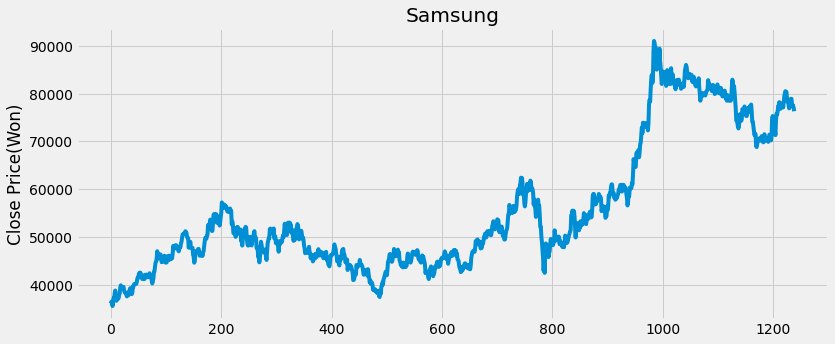

In [7]:
ax = samsung_df['y'].plot(title='Samsung', figsize=(12,5))
ax.set_ylabel('Close Price(Won)')
plt.show()

## Modeling
- Prophet 객체를 생성하고 Fit하여야 합니다.
- Prophet 객체는 1번만 Fit할 수 있습니다. 만약 여러번 하고 싶다면 새로운 객체를 생성해야 합니다.
- 상한과 하한을 설정할 경우 Growth를 조절해야합니다.
```python
m = Prophet(growth='logistic')
m.fit(df)
```

In [8]:
m = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
m.fit(samsung_df)

Initial log joint probability = -7.35712


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3405.67     0.0225971        1120.7       3.546      0.3546      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3629.77     0.0292426       910.747           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3664.06    0.00373991       214.319           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3750.7     0.0299952       906.913      0.4192           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3811.91     0.0451085       2199.15           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

- Future Dataframe을 생성하여야 합니다.
```python
future = m.make_future_dataframe(periods=365)
future.tail()
```
- 예측값의 상한이나 하한을 설정했으면 Future Dataframe에 대해서도 동일하게 지정하여야 합니다.
```python
future['cap'] = 6
future['cap'] = 1.5
```

In [9]:
forecast_time = 90
future = m.make_future_dataframe(periods=90, freq='D')
future.tail(10)

,ds
1319,2022-04-10
1320,2022-04-11
1321,2022-04-12
1322,2022-04-13
1323,2022-04-14
1324,2022-04-15
1325,2022-04-16
1326,2022-04-17
1327,2022-04-18
1328,2022-04-19


- 예측을 진행합니다.
- yhat, yhat_lower, yhat_upper의 범위에서 결과를 제공합니다.

In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-02,35010.397962,32707.710519,37026.925958
1,2017-01-03,35343.422931,33072.582379,37532.796387
2,2017-01-04,35488.083177,33266.217838,37789.917154
3,2017-01-05,35672.683778,33504.652691,37961.826177
4,2017-01-06,35776.993775,33518.370814,38044.294055
...,...,...,...,...
1324,2022-04-15,75849.510866,69403.350211,81949.023473
1325,2022-04-16,76099.236318,69047.393961,82097.150346
1326,2022-04-17,76089.760974,69123.348130,81947.475595
1327,2022-04-18,75850.692339,69020.046115,82697.950200


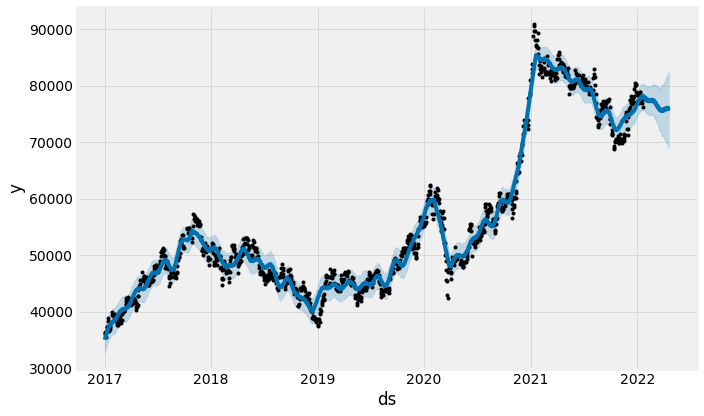

In [11]:
fig1 = m.plot(forecast)

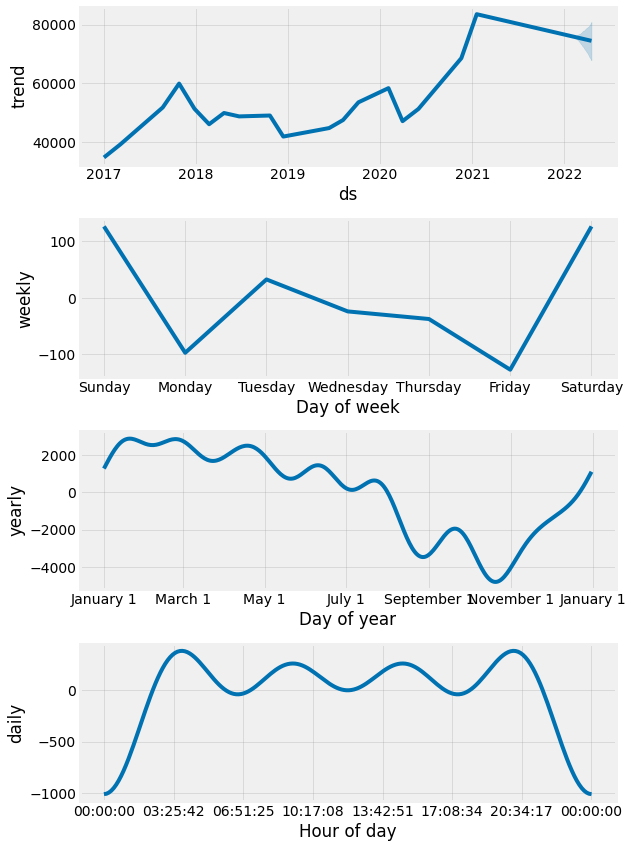

In [12]:
fig2 = m.plot_components(forecast)

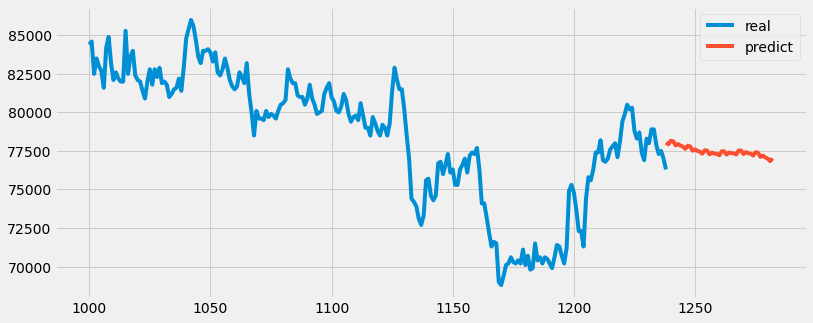

In [13]:
plt.figure(figsize=(12,5))

plt.plot(samsung_df["y"][1000:], label="real")
plt.plot(range(1328-90,1328-45),forecast['yhat'][-90:-45], label="predict")
plt.legend()
plt.show()

## Trend Change Point
- Prophet에서는 기본적으로 Trend가 변경되는 지점을 자동으로 감지해 트렌드를 예측합니다.
- Prophet 객체 생성 시 Changepoint_range, changepoint_prior_scale, changepoints를 조절이 가능합니다.

1) changepoint_range
    - 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 changepoint를 지정합니다.
    - 90%만큼 changepoint로 지정하고 싶다면 아래와 같이 설정할 수 있습니다.
    ```python
    m = Prophet(changepoint_range=0.9)
    ```
    
2) changepoint_prior_scale
    - change point의 유연성을 조정하는 방법입니다.
    - Overfitting이 심하면 너무 유연한 그래프가 나와서 모든 값에 근접하고,
    - Underfitting이 심하면 유연성이 부족합니다.
    - 기본 값은 0.05이나 아래와 같이 설정할 수 있습니다.
    ```python
    m = Prophet(changepoint_prior_scale=0.05)
    ```
    
3) changepoints(list)
    - 잠재적으로 changepoint 일 수 있는 날짜들을 의미합니다.
    - 명시하지 않으면 잠재적인 changepoint가 자동으로 설정됩니다.
    - 특정 날짜를 changepoint로 설정하고 싶다면 아래와 같이 설정 가능합니다.
    ```python
    m = Prophet(changepoints=['2019-02-04'. '2019-02-05'])
    ```

In [14]:
m1 = Prophet(changepoint_prior_scale=0.3, daily_seasonality=True)
m1.fit(samsung_df)

Initial log joint probability = -7.35712


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3424.07       0.23669       7381.95           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3611.49    0.00217446        211.31           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3770.71   0.000902375       168.926      0.2554      0.2554      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3825.58     0.0173439       1459.85      0.8938      0.8938      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3890.1    0.00576628       613.619           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [15]:
forecast_time = 90
future = m1.make_future_dataframe(periods=90, freq='D')
future.tail(10)

,ds
1319,2022-04-10
1320,2022-04-11
1321,2022-04-12
1322,2022-04-13
1323,2022-04-14
1324,2022-04-15
1325,2022-04-16
1326,2022-04-17
1327,2022-04-18
1328,2022-04-19


In [16]:
forecast = m1.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-02,35428.243597,33391.504265,37557.178124
1,2017-01-03,35748.272309,33662.763100,37821.173015
2,2017-01-04,35877.239299,33722.612786,38019.413046
3,2017-01-05,36046.237798,33752.660346,38333.219356
4,2017-01-06,36138.162228,33961.731142,38116.771858
...,...,...,...,...
1324,2022-04-15,75450.452260,68487.885868,83417.032598
1325,2022-04-16,75658.601150,68587.604609,84301.777621
1326,2022-04-17,75644.308161,67865.054734,84263.767464
1327,2022-04-18,75435.830362,67559.503930,84584.593991


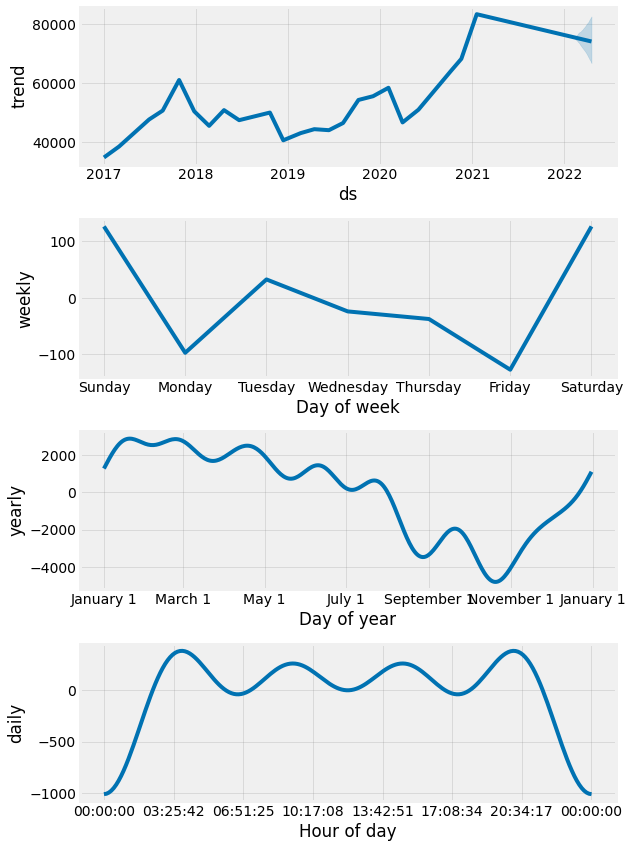

In [17]:
fig2 = m.plot_components(forecast)

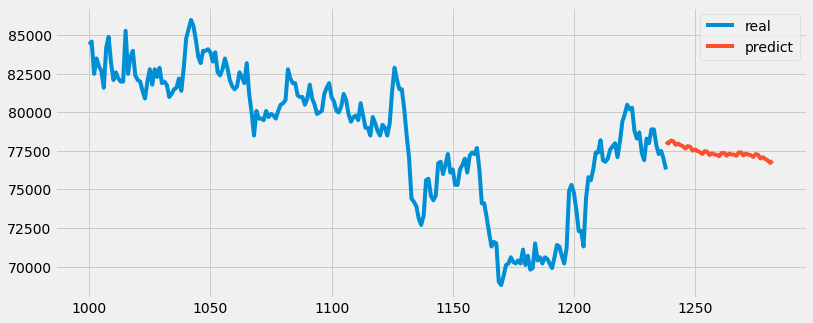

In [18]:
plt.figure(figsize=(12,5))

plt.plot(samsung_df["y"][1000:], label="real")
plt.plot(range(1328-90,1328-45),forecast['yhat'][-90:-45], label="predict")
plt.legend()
plt.show()

## Visualization

ChangePoint의 변화를 다음과 같이 시각화할 수도 있습니다.
- 점선 : Change Point
- 실선 : Trend

ChangePoint의 변화를 Regime Detection에 사용해도 좋을 것 같습니다.

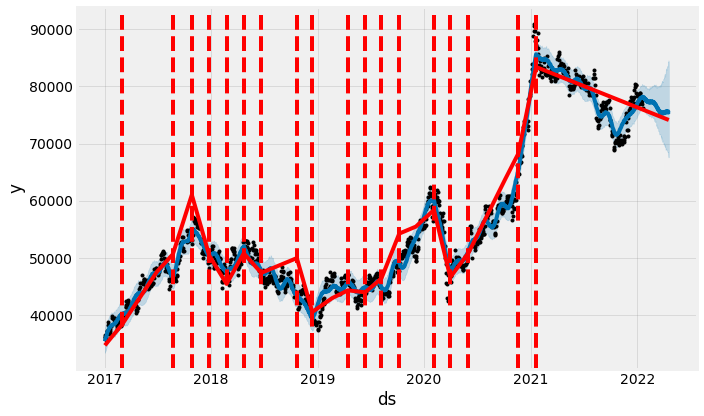

In [22]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)